In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

In [62]:
class Layer(torch.nn.Module):
    
    def __init__(self,size_in,size_out,activation):
        super(Layer,self).__init__()
        self.weights=torch.nn.Parameter(torch.randn(size_in,size_out,requires_grad=True))
        self.bias=torch.nn.Parameter(torch.randn(1,size_out, requires_grad=True))
        self.activation=activation
        
    def Forward(self, z_in):
        return self.activation(z_in@self.weights + self.bias)

# Layer Initialization

In [63]:
forget=Layer(38,15,torch.nn.Sigmoid())
loss_func=torch.nn.MSELoss()
opt=torch.optim.Adam(forget.parameters())

In [64]:
x_in=torch.randn(1,38)
y=torch.rand(1,15)

In [65]:
print(forget.bias)
out=forget.Forward(x_in)
loss=loss_func(out,y)
loss.backward()
opt.step()
opt.zero_grad()
print(forget.bias)

Parameter containing:
tensor([[ 0.7125, -0.4645, -1.1601,  0.6803,  1.2055, -0.2031, -0.4171, -1.2422,
         -0.9039,  1.6963,  0.0483,  0.9568,  0.9997,  0.2072,  1.7926]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.7135, -0.4655, -1.1611,  0.6793,  1.2045, -0.2041, -0.4161, -1.2432,
         -0.9049,  1.6973,  0.0493,  0.9558,  0.9987,  0.2082,  1.7916]],
       requires_grad=True)


In [66]:
 class RNN(torch.nn.Module):
   def __init__(self, size_in,size_out, size_mem):
     super(RNN, self).__init__()
     self.size_mem=size_mem
     self.mem_layer=Layer(size_in + size_mem, size_mem, torch.tanh)
     self.out_layer=Layer(size_mem, size_out, torch.sigmoid)

   def Forward(self, X):
      mem= torch.zeros(1, self.size_mem)
      y_hat=[]
      for i in range (X.shape[0]):
        x_in= X[[i],:]
        z_in=torch.cat([x_in,mem], dim=1)
        mem=self.mem_layer.Forward(z_in)
        y_hat.append(self.out_layer.Forward(mem))

      return torch.cat(y_hat,dim=0)



In [67]:
      rnn=RNN(38,15,5)
      loss_func=torch.nn.MSELoss()
      opt=torch.optim.Adam(rnn.parameters())

In [68]:
print(rnn.mem_layer.bias)
y_hat=rnn.Forward(x_in)
loss=loss_func(y_hat,y)
loss.backward()
opt.step()
opt.zero_grad()
print()
print(rnn.mem_layer.bias)

Parameter containing:
tensor([[ 0.6958, -0.8489, -0.0444,  0.9430,  1.6758]], requires_grad=True)

Parameter containing:
tensor([[ 0.6948, -0.8499, -0.0434,  0.9420,  1.6768]], requires_grad=True)


# Build The LSTM Class
LSTM stands for Long Short Term Memory

In [69]:
class LSTM(torch.nn.Module):
  def __init__(self, size_in, size_out, size_long, size_short):
    super(LSTM,self).__init__()
    self.size_long=size_long
    self.size_short=size_short

    size_z=size_in + size_short

    self.forget_gate=Layer(size_z, size_long, torch.sigmoid)

    self.memory_gate=Layer(size_z,size_long, torch.sigmoid)

    self.memory_layer=Layer(size_z, size_long, torch.tanh)

    self.recall_gate= Layer(size_z, size_short, torch.sigmoid)

    self.recall_layer=Layer(size_long, size_short, torch.tanh)

    self.output_gate= Layer(size_short, size_out, torch.sigmoid)


  def Forward(self, X):
    mem_short= torch.zeros(1, self.size_short)
    mem_long=torch.zeros(1, self.size_long)
    y_hat=[]

    for i in range(X.shape[0]):
      X_t=X[[i],:]
      z_t=torch.cat([X_t, mem_short], dim=1)

      mem_long=mem_long*self.forget_gate.Forward(z_t)
      mem_long= mem_long+(self.memory_gate.Forward(z_t)*self.memory_layer.Forward(z_t))
      mem_short= self.recall_gate.Forward(z_t) * self.recall_layer.Forward(mem_long)    #ther emight be multiplicaiotn here dude instead of addition

      out=self.output_gate.Forward(mem_short)
      out=torch.argmax(out, dim=1)

      y_hat.append(self.output_gate.Forward(mem_short))

    return torch.cat(y_hat, dim=0)

  def Generate(self, start, stop, random_factor):
    y_hat=[start]

    mem_long=torch.randn([1,self.size_long])*random_factor
    mem_short=torch.randn([1,self.size_short])*random_factor

    while(y_hat[-1] != stop).any() and len(y_hat)<30:
      x_t=y_hat[-1]
      z_t=torch.cat([x_t, mem_short], dim=1)

      mem_long=mem_long*self.forget_gate.Forward(z_t)
      mem_long=mem_long + (self.memory_gate.Forward(z_t)*self.memory_layer.Forward(z_t))

      mem_short= self.recall_gate.Forward(z_t) * self.recall_layer.Forward(mem_long) # there might be multiplication here dude instead of addition

      out=self.output_gate.Forward(mem_short)
      
      out=torch.argmax(out, dim=1)

      y_hat.append(torch.zeros(stop.shape))
      y_hat[-1][0, out]=1
    return torch.cat(y_hat, dim=0)

In [70]:
data = pd.read_csv("dinosaurs.csv", sep = ",", header= None)
data.head()

,0
0,aachenosaurus
1,aardonyx
2,abelisaurus
3,abrictosaurus
4,abrosaurus


In [71]:
data.columns = ["name"]

In [72]:
def Process(name):
  name=''.join(['{',name, '|'])
  out=[]
  for letter in name:
    row=torch.zeros([1,28])
    row[0, ord(letter)-97]=1
    out.append(row)
  return torch.cat(out)

def Decode(y_hat):
  out=''
  for i in torch.argmax(y_hat, dim=1):
    out+= chr(i+97)
  return out

In [53]:
## 

In [73]:
lstm = LSTM(28,28,12,12)
loss_func=torch.nn.CrossEntropyLoss()
opt=torch.optim.AdamW(lstm.parameters(), lr=4.5e-2)


r\Iteration: 0 Loss: -0.8886622786521912 |jh{{xxziic{ra  
r\Iteration: 1 Loss: 2.4956471920013428 |jjj{jx|i|g{xqxnzm  
r\Iteration: 2 Loss: 2.3812127113342285 ||{{yo{anqo  
r\Iteration: 3 Loss: 2.3971011638641357 ||haxgqzg||iy  
r\Iteration: 4 Loss: 2.41650390625 ||hax|vjzz|  
r\Iteration: 5 Loss: 2.372002124786377 ||rhj||haggmz  
r\Iteration: 6 Loss: 2.3576066493988037 ||rhax|zmrr|r  
r\Iteration: 7 Loss: 2.4628076553344727 |||i||iaggz|  
r\Iteration: 8 Loss: 2.3002712726593018 |||hyaagxrrrrr||  
r\Iteration: 9 Loss: 2.4239041805267334 |||iiaggj|m||  
r\Iteration: 10 Loss: 2.2857980728149414 |||iohaaii||y  
r\Iteration: 11 Loss: 2.4556524753570557 |||iyy|rhaaa||i|r  
r\Iteration: 12 Loss: 2.3617284297943115 |||||aagx|i|i|||||  
r\Iteration: 13 Loss: 2.3023786544799805 |||i|||ira{aagm||i|y  
r\Iteration: 14 Loss: 2.343553304672241 ||||roagxz|||u|  
r\Iteration: 15 Loss: 2.262342691421509 ||||iy|hax|||iaa  
r\Iteration: 16 Loss: 2.3897361755371094 ||||||aaoazg  
r\Iteration: 17 Loss: 2.

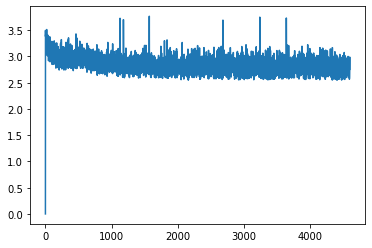

In [74]:
iterations= 4600
losses=[0]
name='{'

for i in range(iterations):

  name = Process(np.random.choice(data.name))
  y_hat=lstm.Forward(name)

  print('r\Iteration: {} Loss: {} |{}'.format(i, loss-1, Decode(y_hat))+ '  ')

  loss= loss_func(y_hat[:-1], torch.argmax(name, dim=1) [1:])

  loss.backward()

  losses.append(loss.detach())

  opt.step()

  opt.zero_grad()

plt.plot(losses)

In [75]:
for i in range(1000):
  print(Decode(lstm.Generate(Process('{')[[1]],Process('')[[1]], 1)))

{anana|
{ananana|
{bosanana|
{hosaurus|
{elanana|
{rosaurus|
{|
{ananana|
{tana|
{urosaus|
{hosaurus|
{sanana|
{ananana|
{ananana|
{ananana|
{elanana|
{|
{sananana|
{hosaurus|
{elanana|
{elanana|
{elananana|
{ananana|
{ananana|
{ranana|
{rananana|
{elananana|
{rosaus|
{ananana|
{nanana|
{alananana|
{ananana|
{hosaurus|
{ananana|
{elanana|
{ratana|
{orananana|
{rosaurus|
{anana|
{elananana|
{anananana|
{hosaurus|
{ananana|
{ranana|
{ananana|
{pananana|
{ananana|
{pananana|
{ananana|
{saurus|
{anana|
{ananana|
{ananana|
{rosaurus|
{eranana|
{osaurus|
{sanana|
{anana|
{y|
{anananana|
{ananana|
{hosaurus|
{osaurus|
{saurus|
{hosaurus|
{elanana|
{sananana|
{rosaurus|
{ananana|
{ananana|
{pananana|
{tanana|
{saurus|
{ananana|
{eratana|
{pananana|
{hosaurus|
{rosaurus|
{ananana|
{ananana|
{ananana|
{rosaurus|
{oratana|
{saurus|
{hosaurus|
{ananana|
{oranana|
{eratana|
{ananana|
{elanana|
{panana|
{ananana|
{anananana|
{ananana|
{tanana|
{sananana|
{osaurus|
{rosaurus|
{saurus|
{anananana|
{ru